# Model Experiments

In this notebook, we will experiment with different machine learning models and their configurations using the Australian Student Performance dataset.

In [2]:
# Import necessary libraries
import sys
import os

sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from src.data.loader import load_data
from src.data.cleaning import clean_data, one_hot_encode
from src.data.balancing import balance_dataset
from src.data.split import split_data
from src.data.pca import principal_component_analysis
from src.data.label_processing import LabelProcessor
from src.models.model_factory import create_model
from src.training.trainer import Trainer
from src.evaluation.evaluate import evaluate_model
from scripts.run_tuning import get_param_grid
from src.training.hyperparameter_tuning import HyperparameterTuner
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline


In [3]:
# Load and clean the data
data = load_data('../data/raw/Australian_Student_PerformanceData (ASPD24).csv')

cleaned_data = clean_data(data)

performance = cleaned_data['Performance']
cleaned_data = cleaned_data.drop('Performance', axis=1)

le = LabelProcessor()
performance = le.encode_labels(performance)
cleaned_data = one_hot_encode(cleaned_data)

cleaned_data['Performance'] = performance
print(cleaned_data.columns)

Index(['Student ID', 'University ID', 'Age', 'Year of Study', 'GPA',
       'High School GPA', 'Entrance Exam Score', 'Attendance Rate',
       'Participation in Extracurricular Activities', 'Part-time Job',
       'Hours of Study per Week', 'Family Income',
       'Distance from Home to University', 'Internet Access at Home',
       'Library Usage', 'Access to Academic Resources', 'Scholarship',
       'Financial Aid', 'Tutor Support', 'Counseling Services',
       'Hours of Sleep per Night', 'Exercise Frequency', 'Peer Support',
       'Use of Online Learning Platforms', 'Project/Assignment Scores',
       'Midterm Exam Scores', 'Final Exam Scores',
       'Attendance at Office Hours', 'Group Work Participation',
       'Research Involvement', 'Internship Experience', 'Peer Reviews',
       'Academic Advising', 'Core Course Average',
       'Extracurricular Participation', 'Peer Evaluations',
       'University Name_University B', 'University Name_University C',
       'Gender_M', 'M

In [4]:
# Balance and split the data
balanced_data = balance_dataset(cleaned_data, target_column='Performance')

Original dataset shape: Counter({4: 23996, 2: 20260, 1: 16050, 3: 11967, 0: 8017})
Balanced dataset shape: Counter({4: 23996, 2: 23996, 1: 23996, 0: 23996, 3: 23996})


In [5]:
# Split the data
X_train_data, X_val_data, X_test_data, y_train_data, y_val_data, y_test_data = split_data(balanced_data.drop('Performance', axis=1), balanced_data['Performance'], test_size=0.2, val_size=0.1)

print(X_train_data.shape, X_val_data.shape, X_test_data.shape)
print(y_train_data.shape, y_val_data.shape, y_test_data.shape)

(95984, 75) (20996, 75) (3000, 75)
(95984,) (20996,) (3000,)


In [6]:
# Use PCA
X_train_PCA, X_val_PCA, X_test_PCA = principal_component_analysis(X_train_data, X_val_data, X_test_data)

print(X_train_PCA.shape, X_val_PCA.shape, X_test_PCA.shape)

(95984, 5) (20996, 5) (3000, 5)


In [8]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


models = {
    "Random Forest": RandomForestClassifier(random_state=5),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=5, probability=True),
    "LightGBM": LGBMClassifier(random_state=5, verbose=-1)
}

In [9]:
param_grids = {
    "Random Forest": {
        # 'clf__criterion': ['entropy'],
        # 'clf__n_estimators': np.arange(445, 446, 1),
        # 'clf__max_depth': [None],
        # 'clf__min_samples_split': np.arange(9, 10, 1),
        # 'clf__min_samples_leaf': [1],
        # 'clf__class_weight': [None]
    },
    "KNN": {
        # 'clf__n_neighbors': np.arange(89, 90, 1),
        # 'clf__weights': ['distance'],
        # 'clf__metric': ['manhattan'],
        # 'clf__algorithm': ['auto'],
        # 'clf__leaf_size': np.arange(1, 2, 1),
    },
    "SVM": {
        # 'clf__kernel': ['rbf'],
        # 'clf__gamma': ['scale'],
        # 'clf__decision_function_shape': ['ovo'],
        # 'clf__C': [1],
        # 'clf__degree': [0],
    },
    "LightGBM": {
        # 'clf__n_estimators': [231],
        # 'clf__learning_rate': [0.05],
        # 'clf__num_leaves': [18,],
        # 'clf__max_depth': [-1],
        # 'clf__min_child_samples': [20],
        # 'clf__subsample': [0.1],
        # 'clf__colsample_bytree': [0.9],
        # 'clf__reg_alpha': [0.0],
        # 'clf__reg_lambda': [0.5],
        # 'clf__scale_pos_weight': [2.0217917675544794],
    }
}

In [10]:
import math
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
results = []

X = pd.DataFrame(np.vstack([X_train_PCA, X_val_PCA, X_test_PCA]))
y = pd.Series(np.hstack([y_train_data, y_val_data, y_test_data]))
X = X[:math.floor(len(X)/100)]
y = y[:math.floor(len(y)/100)]
print(X.shape, y.shape)

for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    
    grid = GridSearchCV(pipeline, param_grid=param_grids[name], cv=cv,
                        scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
    grid.fit(X, y)
    
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best CV AUC for {name}: {grid.best_score_:.4f}\n")
    
    best_models[name] = grid.best_estimator_
    
    # Evaluate best model on CV splits for Accuracy and AUC

    classes = np.unique(y)

    acc_scores = []
    auc_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model_cv = grid.best_estimator_
        model_cv.fit(X_train, y_train)
        
        y_pred = model_cv.predict(X_val)
        acc = (y_pred == y_val).mean()
        
        # Binarize y_val for multiclass ROC AUC
        y_val_bin = label_binarize(y_val, classes=classes)
        y_proba = model_cv.predict_proba(X_val)
        
        # Compute ROC AUC for each class separately
        aucs_per_class = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            aucs_per_class.append(roc_auc)
        
        # Average AUC over all classes for this fold
        mean_auc = np.mean(aucs_per_class)
        
        acc_scores.append(acc)
        auc_scores.append(mean_auc)

    results.append({
        'Model': name,
        'Mean Accuracy': np.mean(acc_scores),
        'Std Accuracy': np.std(acc_scores),
        'Mean AUC': np.mean(auc_scores),
        'Std AUC': np.std(auc_scores)
    })

plt.figure(figsize=(8, 6))
mean_fpr = np.linspace(0, 1, 100)

print('Best models:')
for m in best_models.items():
    print(m)
print('Results:')
for r in results:
    print(r)

(1199, 5) (1199,)
Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Random Forest: {}
Best CV AUC for Random Forest: 0.6230

Running GridSearchCV for KNN...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for KNN: {}
Best CV AUC for KNN: 0.5942

Running GridSearchCV for SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for SVM: {}
Best CV AUC for SVM: 0.6606

Running GridSearchCV for LightGBM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for LightGBM: {}
Best CV AUC for LightGBM: 0.5998

Best models:
('Random Forest', Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=5))]))
('KNN', Pipeline(steps=[('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]))
('SVM', Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(probability=True, random_state

<Figure size 800x600 with 0 Axes>

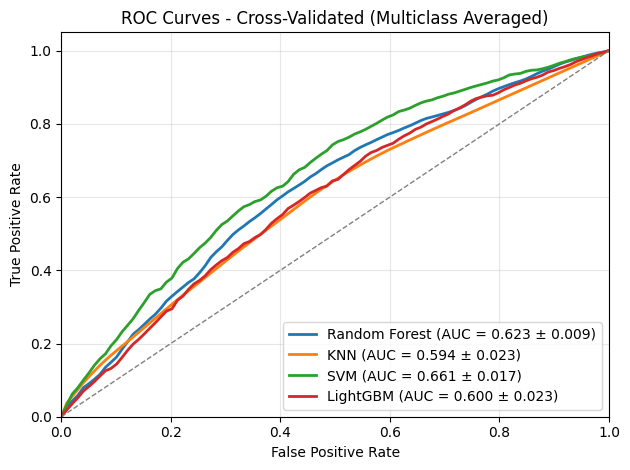

In [11]:
# Create a ROC graph
mean_fpr = np.linspace(0, 1, 100)

for name, model in best_models.items():
    tprs = []  # will hold TPRs averaged over classes per fold
    aucs = []  # will hold average AUC over classes per fold
    
    classes = np.unique(y)  # unique classes once outside folds

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        
        y_val_bin = label_binarize(y_val, classes=classes)
        y_proba = model.predict_proba(X_val)
        
        tprs_per_class = []
        aucs_per_class = []

        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs_per_class.append(interp_tpr)
            auc_score = auc(fpr, tpr)
            aucs_per_class.append(auc_score)
        
        # Average TPR and AUC across classes for this fold
        mean_tpr_fold = np.mean(tprs_per_class, axis=0)
        tprs.append(mean_tpr_fold)
        mean_auc_fold = np.mean(aucs_per_class)
        aucs.append(mean_auc_fold)

    # Average over all folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # ensure curve ends at (1,1)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr,
             label=f"{name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
             lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Cross-Validated (Multiclass Averaged)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\valkrasm\AppData\Local\Temp\ipykernel_9620\2931595581.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


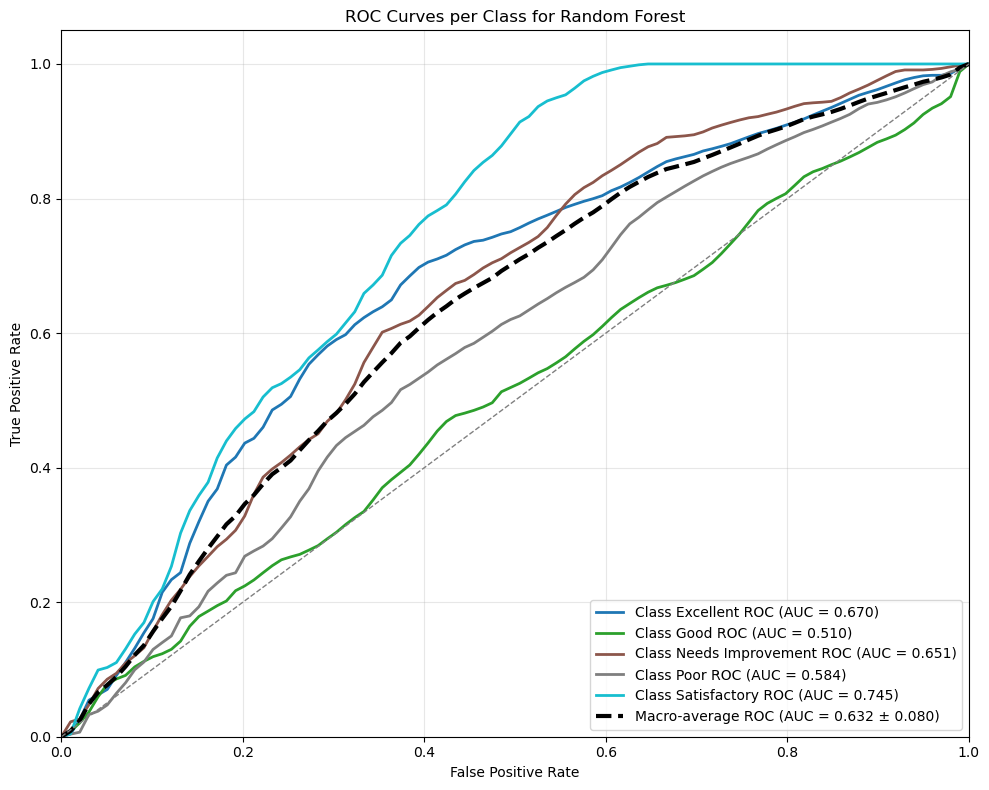

C:\Users\valkrasm\AppData\Local\Temp\ipykernel_9620\2931595581.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


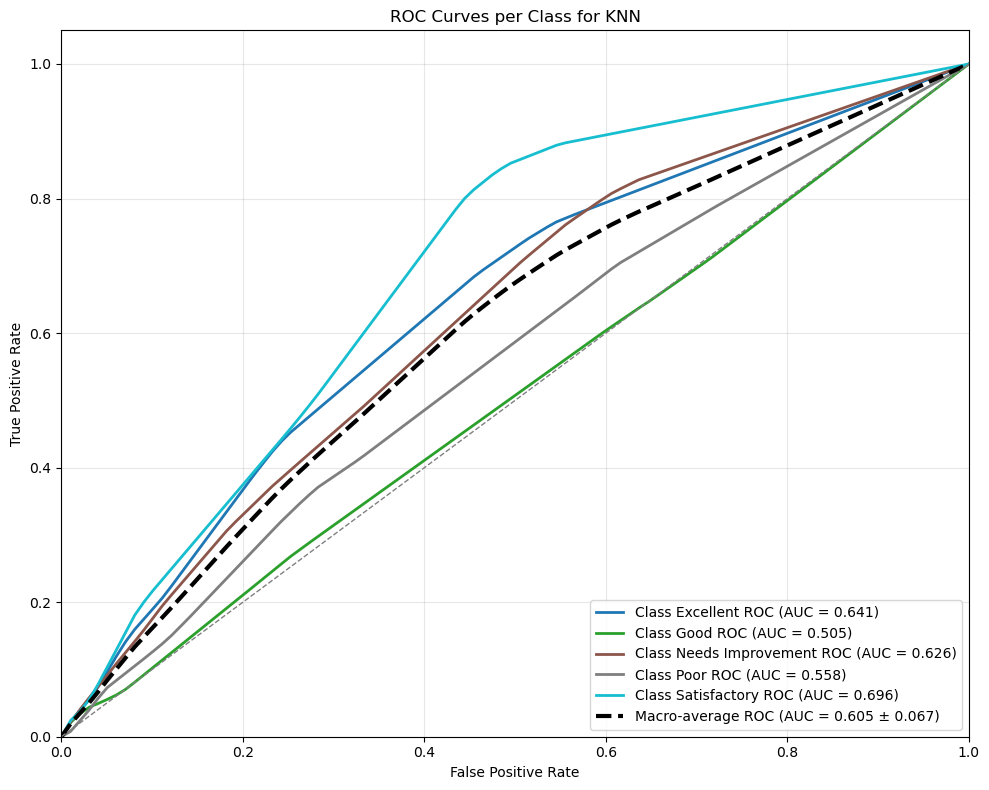

C:\Users\valkrasm\AppData\Local\Temp\ipykernel_9620\2931595581.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


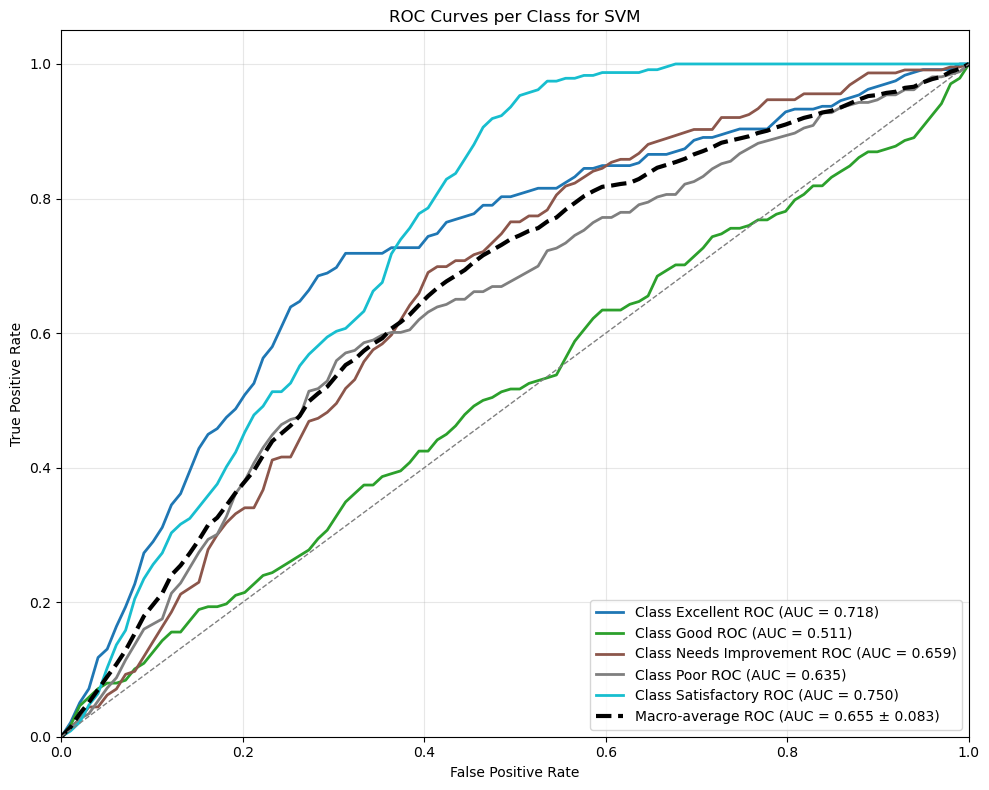

C:\Users\valkrasm\AppData\Local\Temp\ipykernel_9620\2931595581.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


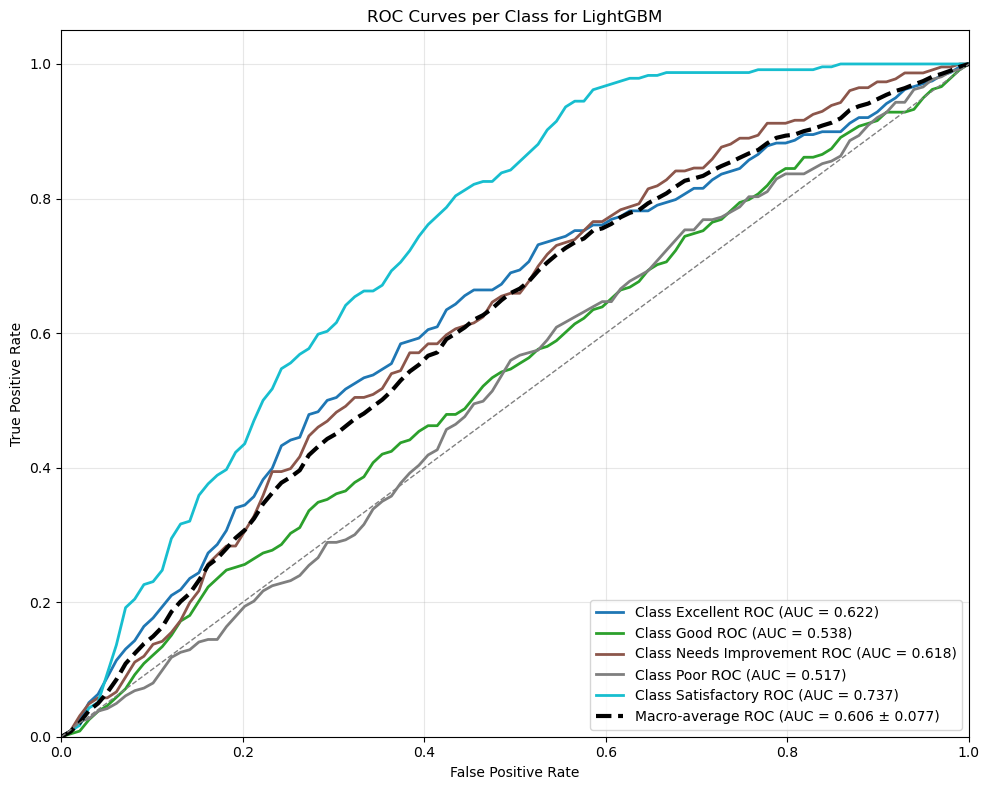

In [ ]:
mean_fpr = np.linspace(0, 1, 100)

for j, (name, model) in enumerate(best_models.items()):
    plt.figure(figsize=(10, 8))
    classes = np.unique(y)
    n_classes = len(classes)

    # Store TPRs and AUCs for macro-average
    tprs_macro = []
    aucs_macro = []

    # Per-class colors for clarity
    colors = plt.cm.get_cmap('tab10', n_classes)

    for i, cls in enumerate(classes):
        tprs = []
        aucs = []

        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            y_val_bin = label_binarize(y_val, classes=classes)
            y_proba = model.predict_proba(X_val)

            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0

            tprs.append(interp_tpr)
            aucs.append(auc(fpr, tpr))

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)

        # Save for macro average
        tprs_macro.append(mean_tpr)
        aucs_macro.append(mean_auc)

        # Plot per-class ROC curve
        plt.plot(mean_fpr, mean_tpr, color=colors(i),
                 label=f'Class {le.decode_labels(classes)[cls]} ROC (AUC = {mean_auc:.3f})', lw=2) # MAY BE WRONG

    # Plot macro-average ROC curve
    macro_tpr = np.mean(tprs_macro, axis=0)
    macro_tpr[-1] = 1.0
    macro_auc = np.mean(aucs_macro)
    std_auc = np.std(aucs_macro)

    plt.plot(mean_fpr, macro_tpr, color='black',
             label=f'Macro-average ROC (AUC = {macro_auc:.3f} ± {std_auc:.3f})',
             lw=3, linestyle='--')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves per Class for {name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
